In [1]:
import os
import sys
import json
import torch
import numpy as np
from torch import nn

import matplotlib
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':12,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.networks.wgan import GoodNetwork
from DiffNet.DiffNetFDM import DiffNetFDM
from DiffNet.datasets.single_instances.klsum import Dataset
from DiffNet.datasets.single_instances.rectangles import RectangleManufactured

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42


In [2]:
class Poisson(DiffNetFDM):
    """docstring for Poisson"""
    def __init__(self, network, dataset, **kwargs):
        super(Poisson, self).__init__(network, dataset, **kwargs)
        x = np.linspace(0,1,self.domain_size)
        y = np.linspace(0,1,self.domain_size)
        xx, yy = np.meshgrid(x,y)
        self.u_exact = torch.tensor(np.sin(np.pi*xx)*np.sin(np.pi*yy))

        self.h = 1. / (self.domain_size - 1)

    def test(self):
        x = torch.linspace(0, 1., 64)
        y = torch.linspace(0, 1., 64)
        xv, yv = torch.meshgrid(x, y)

        print("x = ", xv)
        print("y = ", yv)
        print("sobelx = ", self.sobelx)
        print("sobely = ", self.sobely)

        print("sobelxx = ", self.sobelxx)
        print("sobelyy = ", self.sobelyy)

        sinx = torch.sin(np.pi * xv).type_as(next(self.network.parameters()))
        dxsinx = nn.functional.conv2d(sinx.unsqueeze(0).unsqueeze(0), self.sobelx)
        dysinx = nn.functional.conv2d(sinx.unsqueeze(0).unsqueeze(0), self.sobely)

        fig, axs = plt.subplots(2, 2, figsize=(2*2,1.2*2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax_row in axs:
            for ax in ax_row:
                ax.set_xticks([])
                ax.set_yticks([])

        im0 = axs[0][0].imshow(sinx.squeeze().detach().cpu(),cmap='jet')
        fig.colorbar(im0, ax=axs[0,0])
        im1 = axs[1][0].imshow(dxsinx.squeeze().detach().cpu(),cmap='jet')
        fig.colorbar(im1, ax=axs[1,0])  
        im1 = axs[1][1].imshow(dysinx.squeeze().detach().cpu(),cmap='jet')
        fig.colorbar(im1, ax=axs[1,1])  
        
        plt.savefig(os.path.join(self.logger[0].log_dir, 'check_' + str(self.current_epoch) + '.png'))
        # self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all')
        exit()


    def loss(self, u, inputs_tensor, forcing_tensor):

        # self.test()

        f = forcing_tensor # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]

        # apply boundary conditions
        # u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)

        u_x = nn.functional.conv2d(u, self.sobelx)
        u_y = nn.functional.conv2d(u, self.sobely)
        u_xx = nn.functional.conv2d(u, self.sobelxx)
        u_yy = nn.functional.conv2d(u, self.sobelyy)
        u_laplacian = u_xx + u_yy

        nu_x = nn.functional.conv2d(nu, self.sobelx)
        nu_y = nn.functional.conv2d(nu, self.sobely)

        gradU_DOT_gradNU = torch.mul(u_x, nu_x) + torch.mul(u_y, nu_y)

        # print("size of nu_x = ", nu_x.shape)
        # print("size of nu[:,:,1:-1,1:-1] = ", nu[:,:,1:-1,1:-1].shape)
        # print("size of u_x = ", u_x.shape)
        # print("size of u_laplacian = ", u_laplacian.shape)
        # exit()

        res = f[:,:,1:-1,1:-1] + gradU_DOT_gradNU + torch.mul(nu[:,:,1:-1,1:-1], u_laplacian)
        # print("res size = ", (res.view(u.shape[0], -1)).shape)

        loss1 = torch.norm(res.view(u.shape[0], -1), p=1, dim=1)
        loss2 = torch.norm(res.view(u.shape[0], -1), p=2, dim=1)

        # print("loss1 = ", loss1, ", size = ", loss1.shape)
        # print("loss2 = ", loss2, ", size = ", loss2.shape)
        # exit()
        # return (0.1*loss1 + 0.9*loss2)
        return loss2

        # nu_gp = self.gauss_pt_evaluation(nu)
        # f_gp = self.gauss_pt_evaluation(f)
        # u_gp = self.gauss_pt_evaluation(u)
        # u_x_gp = self.gauss_pt_evaluation_der_x(u)
        # u_y_gp = self.gauss_pt_evaluation_der_y(u)

        # transformation_jacobian = self.gpw.unsqueeze(-1).unsqueeze(-1).unsqueeze(0).type_as(nu_gp)
        # res_elmwise = transformation_jacobian * (nu_gp * (u_x_gp**2 + u_y_gp**2) - (u_gp * f_gp))
        # res_elmwise = torch.sum(res_elmwise, 1) 

        # loss = torch.mean(res_elmwise)
        # return loss

    def forward(self, batch):
        inputs_tensor, forcing_tensor = batch
        return self.network[0], inputs_tensor, forcing_tensor

    def configure_optimizers(self):
        """
        Configure optimizer for network parameters
        """
        # lr = self.learning_rate
        opts = [torch.optim.LBFGS(self.network, lr=0.1, max_iter=4)]
        # return opts, []
        # opts = [torch.optim.Adam(self.network.parameters(), lr=1e-3)]
        schd = []
        schd = [torch.optim.lr_scheduler.MultiStepLR(opts[0], milestones=[2,5,10], gamma=0.1)]
        return opts, schd
    
    def do_query(self, inputs, forcing):
        u, inputs_tensor, forcing_tensor = self.forward((inputs.unsqueeze(0).type_as(next(self.network.parameters())), 
                                                         forcing.unsqueeze(0).type_as(next(self.network.parameters()))))
        
        f = forcing_tensor.squeeze().detach().cpu() # renaming variable
        
        # extract diffusivity and boundary conditions here
        nu = inputs_tensor[:,0:1,:,:]
        bc1 = inputs_tensor[:,1:2,:,:]
        bc2 = inputs_tensor[:,2:3,:,:]        
        # process diffusivity
        k = nu.squeeze().detach().cpu()

        # process u (by adding BC)
        u = torch.where(bc1>0.5,1.0+u*0.0,u)
        u = torch.where(bc2>0.5,u*0.0,u)        
        u = u.squeeze().detach().cpu()
        
        return u, k, f
    
    def plot_contours_to_logger(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        # plt.show()
        plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
        self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
        plt.close('all') 
        
    def plot_contours(self,k,f,u,u_exact):
        diff = u - u_exact
        # plotting        
        fig, axs = plt.subplots(1, 5, figsize=(3*5,2),
                            subplot_kw={'aspect': 'auto'}, sharex=True, sharey=True, squeeze=True)
        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])              
        
        # print(np.linalg.norm(diff.flatten())/self.domain_size)
        im = axs[0].imshow(f,cmap='jet')
        fig.colorbar(im, ax=axs[0], ticks=[0.0, 4.0, 8.0, 12.0, 16.0, 20.0]); axs[0].set_title(r'$f$')
        im = axs[1].imshow(k,cmap='jet')
        fig.colorbar(im, ax=axs[1]); axs[1].set_title(r'$\nu$')
        im = axs[2].imshow(u,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[2]); axs[2].set_title(r'$u_{\theta}$')
        im = axs[3].imshow(u_exact,cmap='jet', vmin=0.0, vmax=1.0)
        fig.colorbar(im, ax=axs[3]); axs[3].set_title(r'$u_{exact}$')
        im = axs[4].imshow(diff,cmap='jet')
        fig.colorbar(im, ax=axs[4]); axs[4].set_title(r'$u_{\theta}-u_{exact}$')
        plt.show()

    def on_epoch_end(self):
        self.network.eval()
        inputs, forcing = self.dataset[0]
        u, k, f = self.do_query(inputs, forcing)                
        
        u_exact = self.u_exact.squeeze().detach().cpu()
        diff = u - u_exact
        
        self.plot_contours_to_logger(k,f,u,u_exact)

In [3]:
u_tensor = np.ones((1,1,64,64))
network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
# dataset = Dataset('example-coefficients.txt', domain_size=64)
dataset = RectangleManufactured(domain_size=64)
basecase = Poisson(network, dataset, batch_size=1)

# ------------------------
# 1 INIT TRAINER
# ------------------------
logger = pl.loggers.TensorBoardLogger('.', name="fdm-mms")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = Trainer(gpus=[0],callbacks=[early_stopping],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=25, deterministic=True, profiler="simple")

# ------------------------
# 4 Training
# ------------------------

trainer.fit(basecase)

# ------------------------
# 5 SAVE NETWORK
# ------------------------
torch.save(basecase.network, os.path.join(logger.log_dir, 'network.pt'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./fdm-mms/version_6 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name    | Type          | Params
------------------------------------------
0 | network | ParameterList | 4.1 K 
------------------------------------------
4.1 K     Trainable params
54        Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Epoch 0:  10%|█         | 10/100 [00:00<00:01, 54.48it/s, loss=1.56e+04, v_num=6_6]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 36 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 24: 100%|██████████| 100/100 [00:02<00:00, 43.78it/s, loss=2.75, v_num=6_6]  

FIT Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  86.569         	|  100 %          	|
--------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  3.2968         	|25             	|  82.419         	|  95.206         	|
run_training_batch                 	|  0.02365        	|2500           	|  59.124         	|  68.296         	|
optimizer_step_and_closure_0       	|  0.02339        	|2500           	|  58.476         	|  67.548         	|
on_epoch_end                       	|  0.64765        	|25             	|  16.191         	|  18.703         	|
training_step_and_backward         

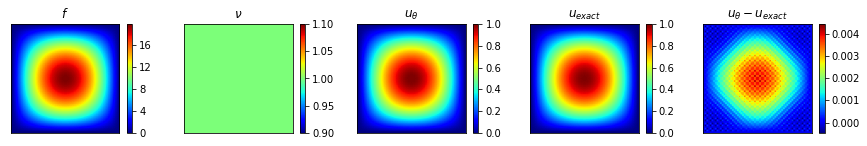

In [4]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, k, f = basecase.do_query(inputs, forcing) 
u_exact = basecase.u_exact.squeeze().detach().cpu()
# plot
basecase.plot_contours(k,f,u,u_exact)